In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as ms

ms.use('seaborn-muted')
%matplotlib inline
import librosa
import librosa.display

# загрузка mp3 файлов
import audioread.ffdec  # Use ffmpeg decoder
import ffmpeg

from glob import glob
import os

#pytorch
import torch
import torch.nn as nn
from torchvision import transforms

In [2]:
songs_dir = './music'
songs_names = glob(songs_dir+ "\*.mp3")
y, sr = librosa.load(audioread.ffdec.FFmpegAudioFile(songs_names[0]))

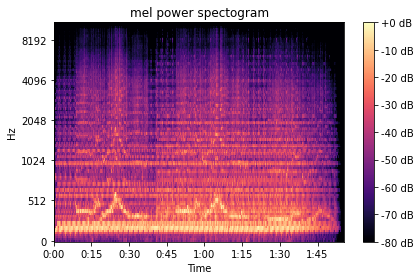

In [3]:
#Mel Spectogram
S = librosa.feature.melspectrogram(y = y, sr = sr, n_mels = 128)

#convert to log scale
log_S = librosa.power_to_db(S, ref = np.max)

#display the spectogram on a mel scale
# sample rate and hop length parameters are used to rener the time axis
librosa.display.specshow(log_S, sr = sr, x_axis = 'time', y_axis = 'mel')

plt.title('mel power spectogram')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

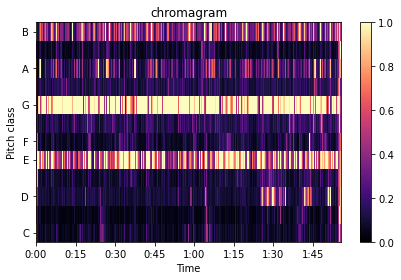

In [4]:
y_harmonic, y_percussive = librosa.effects.hpss(y)

C = librosa.feature.chroma_cqt(y=y_harmonic, sr = sr)

librosa.display.specshow(C, sr=sr, x_axis='time', y_axis = 'chroma', vmin = 0, vmax = 1)

plt.title("chromagram")
plt.colorbar()
plt.tight_layout()

In [2]:
songs_dir = './csv_data'
songs_names = glob(songs_dir+ "\*.csv")


In [3]:
class CENSDataset(torch.utils.data.Dataset):   
    def __init__(self, songs_names):
        
        self.transform = transforms.Compose(
            [
                #transforms.Resize((10,10)), 
                transforms.ToTensor()
            ]
        )
        df = pd.DataFrame()
        self.songs_names = songs_names
        
        train_songs_names= [song.split('\\')[-1].split('.')[0] for song in songs_names]
        self.y_dict_reverse = {i : train_songs_names[i] for i in range(len(train_songs_names))}
        for i, song_name in enumerate(songs_names):
            df_to_merge = pd.read_csv(song_name, skiprows = 1, header = None)
            df_to_merge['y'] = np.full(len(df_to_merge), i) 
            df = pd.concat([df, df_to_merge])

        self.data = self.transform(df.drop('y', axis = 1))
        self.y = self.transform(df['y'])

    def __len__(self):
        return len(self.y)

    def __getitem__(self, index):
        
        img = self.data[index]      
        target = self.y[index]
        
        return img, target

In [6]:
def load_cens_pandas(load_dir):
    df = pd.DataFrame()
    songs_names = glob(songs_dir+ "\*.csv")
    train_songs_names= [song.split('\\')[-1].split('.')[0] for song in songs_names]
    y_dict_reverse = {i : train_songs_names[i] for i in range(len(train_songs_names))}
    for i, song_name in enumerate(songs_names):
        df_to_merge = pd.read_csv(song_name, skiprows = 1, header = None)
        df_to_merge['y'] = np.full(len(df_to_merge), i) 
        df = pd.concat([df, df_to_merge])
    return y_dict_reverse, df

In [14]:
csv_dir = './csv_data'    
rev_dict, df = load_cens_pandas(csv_dir)
X = df.drop('y', axis = 1)
y = df['y']

In [15]:
X.shape

(9103, 3876)

In [9]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

In [10]:

parameters = {'C': [0.1, 0.5,  1, 2]}
kf_svm = StratifiedKFold(shuffle=True, random_state = 0)
svc = LinearSVC()

clf_svm = GridSearchCV(svc, parameters, cv=kf_svm, verbose = 10)

clf_svm.fit(train_X, train_y)

NameError: name 'train_X' is not defined

In [60]:
clf_svm.cv_results_

{'mean_fit_time': array([0.37466717, 0.37922549]),
 'std_fit_time': array([0.00404013, 0.01431943]),
 'mean_score_time': array([0.00298777, 0.00137911]),
 'std_score_time': array([0.00303078, 0.00049059]),
 'param_C': masked_array(data=[0.1, 1],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 0.1}, {'C': 1}],
 'split0_test_score': array([0.89285714, 0.89285714]),
 'split1_test_score': array([0.96428571, 0.96428571]),
 'split2_test_score': array([0.96296296, 0.96296296]),
 'split3_test_score': array([0.85185185, 0.85185185]),
 'split4_test_score': array([0.96296296, 0.96296296]),
 'mean_test_score': array([0.92698413, 0.92698413]),
 'std_test_score': array([0.046454, 0.046454]),
 'rank_test_score': array([1, 1])}

In [16]:
neigh = KNeighborsClassifier()
parameters = {'n_neighbors':[3,5,7,9]}

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
kf.get_n_splits(X, y)

clf_knn = GridSearchCV(neigh, parameters, cv=kf, verbose = 10)

In [17]:
clf_knn.fit(X, y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5; 1/4] START n_neighbors=3...............................................
[CV 1/5; 1/4] END .............................n_neighbors=3; total time=   1.0s
[CV 2/5; 1/4] START n_neighbors=3...............................................
[CV 2/5; 1/4] END .............................n_neighbors=3; total time=   1.0s
[CV 3/5; 1/4] START n_neighbors=3...............................................
[CV 3/5; 1/4] END .............................n_neighbors=3; total time=   1.0s
[CV 4/5; 1/4] START n_neighbors=3...............................................
[CV 4/5; 1/4] END .............................n_neighbors=3; total time=   1.0s
[CV 5/5; 1/4] START n_neighbors=3...............................................
[CV 5/5; 1/4] END .............................n_neighbors=3; total time=   1.1s
[CV 1/5; 2/4] START n_neighbors=5...............................................
[CV 1/5; 2/4] END .............................n_

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
             estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [3, 5, 7, 9]}, verbose=10)

In [18]:
clf_knn.cv_results_

{'mean_fit_time': array([0.16296473, 0.16276579, 0.16695361, 0.16116862]),
 'std_fit_time': array([0.00720817, 0.00806281, 0.01271921, 0.00669318]),
 'mean_score_time': array([0.96249213, 1.06218448, 1.01159382, 1.00713267]),
 'std_score_time': array([0.03770828, 0.03880325, 0.01518145, 0.02058781]),
 'param_n_neighbors': masked_array(data=[3, 5, 7, 9],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_neighbors': 3},
  {'n_neighbors': 5},
  {'n_neighbors': 7},
  {'n_neighbors': 9}],
 'split0_test_score': array([0.80395387, 0.77375069, 0.72817133, 0.70126304]),
 'split1_test_score': array([0.78308622, 0.74848984, 0.71334432, 0.69137836]),
 'split2_test_score': array([0.78583196, 0.75507963, 0.72158155, 0.69467326]),
 'split3_test_score': array([0.80879121, 0.76868132, 0.71483516, 0.67802198]),
 'split4_test_score': array([0.7956044 , 0.75      , 0.72472527, 0.6956044 ]),
 'mean_test_score': array([0.79545353, 0.75920029